In [1]:
# Supress seaborn FutureWarning (need old version for statannotations)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from statannotations.Annotator import Annotator

Change seaborn styling.

In [2]:
sns.set_theme(
    style='ticks',
    context='paper',
    rc={"axes.spines.right": False, "axes.spines.top": False},
    font_scale=1.5,
)
np.random.seed(98)

POINT_SIZE = 6
POINT_COLOR = '#454545'

Read in count data.

In [3]:
file_sample_names = ['input', 'liquid', 'semisolid', 'large_plate', 'small_plate', 'bead']
names_dict = {'liquid': 'liquid', 'semisolid': 'semisolid', 'small_plate': 'high-density spread', 'bead': 'bead spread', 'large_plate': 'low-density spread', 'input': 'input'}
sample_names = [names_dict[name] for name in file_sample_names]
counts = []

for sample in file_sample_names:
    for replicate in range(1, 5):
        with open(f'../data/counts/MORF_{sample}_{replicate}.txt', 'rt') as f:
            clusters = (x.split("\t") for x in f.read().splitlines())
            for center, count in clusters:
                counts.append((names_dict[sample], replicate, center, int(count)))

count_df = pd.DataFrame(counts, columns=['sample', 'replicate', 'sequence', 'count'])
count_df.head()

,sample,replicate,sequence,count
0,input,1,TAGTTGGGAAGGAGAATTCATCTT,1019
1,input,1,GCATGGGCTAGTTGAGCATTTGTG,739
2,input,1,GGGATGTAGTGATACACATCATAA,652
3,input,1,TCAGAACGCATTGTAACGCAAGGC,628
4,input,1,TTCCGTTAATGTCAAGTAGAAGGT,619


Read in MORF library data.

In [4]:
MORF_df = pd.read_csv('../data/200102_tf_orf_library.csv')
MORF_df.head()

,Name,RefSeq Gene Name,RefSeq and Gencode ID,Barcode Sequence,ORF sequence,Full sequence,Notes 1,Notes 2
0,TFORF0001,HIF3A,"NM_022462,ENST00000244303",AGTCAAGACCCTCGGGCTCTGTGG,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
1,TFORF0002,HIF3A,"NM_152796,ENST00000472815",CAATTACACCACGTCTGCCTACTA,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
2,TFORF0003,HIF3A,"NM_152794,ENST00000300862",TTCAGACGTTTCGCGCCTGGAGCT,ATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGCGCAAGGAAA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
3,TFORF0004,HIF3A,"XM_005259153,ENST00000600383",GATAACGCTAACCACAAGGTATTT,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
4,TFORF0005,HIF3A,"NM_152795,ENST00000377670",CCACGCGAGCTAGACGATCGATGA,ATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGGAGCTGCGCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN


In [5]:
print('Number of MORF sequences:', len(MORF_df))
print('Minumum length of MORF sequences:', MORF_df['ORF sequence'].apply(len).min())
print('Maximum length of MORF sequences:', MORF_df['ORF sequence'].apply(len).max())

Number of MORF sequences: 3548
Minumum length of MORF sequences: 150
Maximum length of MORF sequences: 9690


Plot distribution of MORF insert sizes.

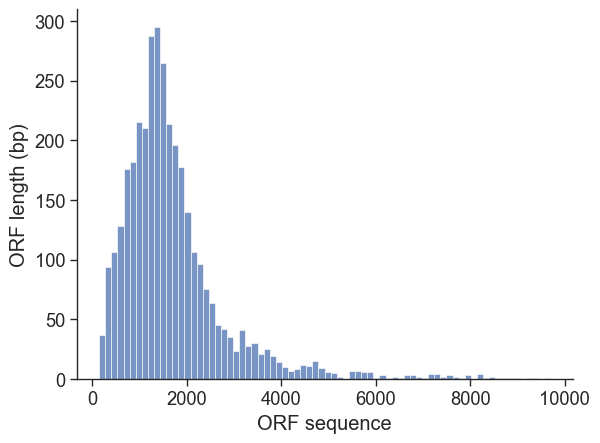

In [6]:
sns.histplot(x=MORF_df['ORF sequence'].apply(len))
plt.ylabel('ORF length (bp)')
plt.show()

Merge the count dataframe with the MORF info dataframe, keeping only sequences that exactly match a barcode in the MORF library.

In [7]:
merged_df = pd.merge(count_df, MORF_df[['Barcode Sequence', 'Name', 'ORF sequence']], left_on='sequence', right_on='Barcode Sequence', how='inner')
merged_df['ORF length'] = merged_df['ORF sequence'].apply(len)
merged_df = merged_df[['sample', 'replicate', 'sequence', 'count', 'Name', 'ORF length']]
merged_df.head()

,sample,replicate,sequence,count,Name,ORF length
0,input,1,TAGTTGGGAAGGAGAATTCATCTT,1019,TFORF2750,1101
1,input,2,TAGTTGGGAAGGAGAATTCATCTT,868,TFORF2750,1101
2,input,3,TAGTTGGGAAGGAGAATTCATCTT,950,TFORF2750,1101
3,input,4,TAGTTGGGAAGGAGAATTCATCTT,829,TFORF2750,1101
4,liquid,1,TAGTTGGGAAGGAGAATTCATCTT,850,TFORF2750,1101


Calculate various statistics for each sample and plot them.

In [8]:
# from https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy
# Gini is the mean absolute difference of all value pairs, normalized by the value average
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [9]:
sample_stats = []
for rep in range(1, 5):
    for sample in sample_names:
        sample_counts = merged_df.loc[(merged_df['replicate'] == rep) & (merged_df['sample'] == sample)]['count']
        nobs, minmax, mean, var, skew, kurtosis = stats.describe(sample_counts)
        reads = sample_counts.sum()
        gini = gini_coefficient(np.array(sample_counts))
        median = np.median(sample_counts)
        stdev = np.std(sample_counts)
        sample_stats.append((sample, rep, nobs, reads, minmax[1], mean, median, stdev, skew, kurtosis, gini))
col_names = ['sample', 'rep', 'unique seqs', 'reads', 'max', 'mean', 'median', 'stdev', 'skew', 'kurtosis', 'gini']
sample_stats_df = pd.DataFrame(sample_stats, columns=col_names).melt(id_vars=['sample', 'rep'])

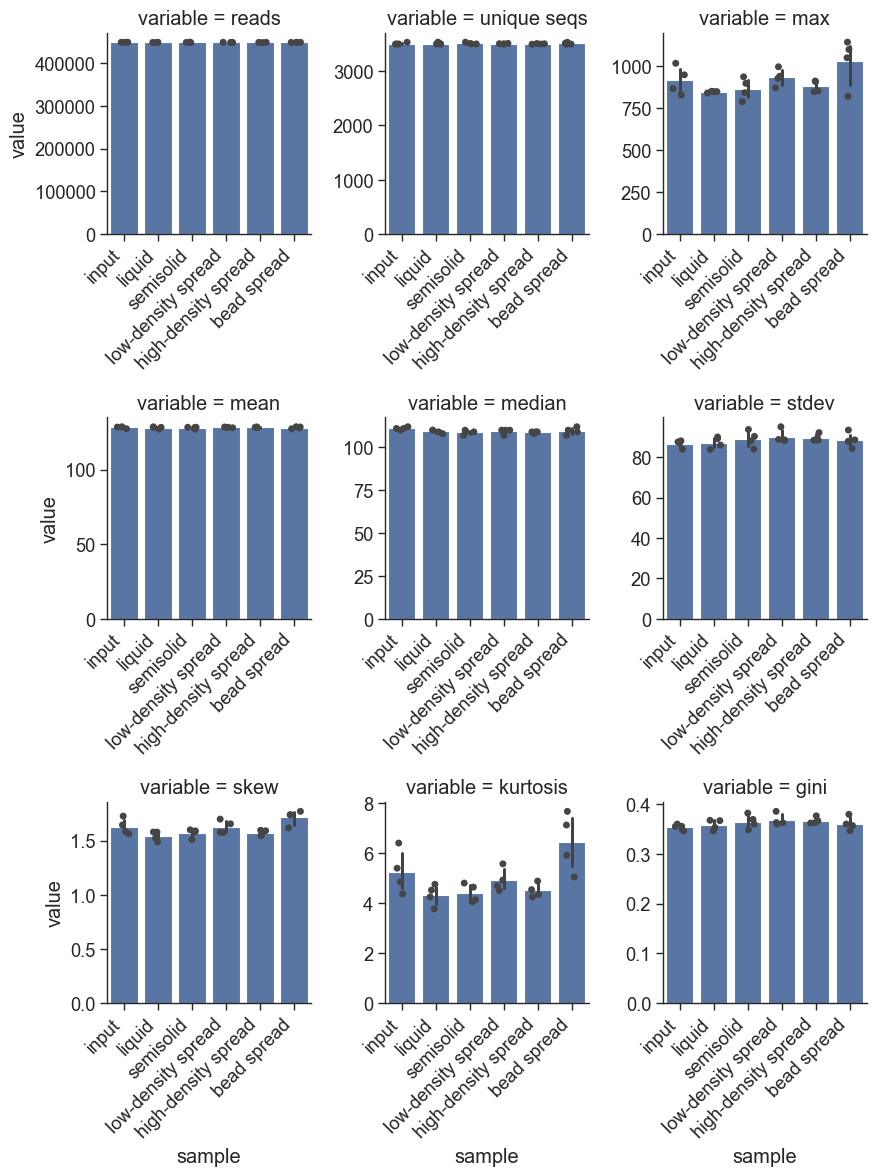

In [10]:
g = sns.FacetGrid(
    sample_stats_df, col='variable',
    col_order=['reads', 'unique seqs', 'max', 'mean', 'median', 'stdev', 'skew', 'kurtosis', 'gini'],
    col_wrap=3, height=4, aspect=0.75, sharex=False, sharey=False
)
g.map(sns.barplot, 'sample', 'value', order=sample_names)
g.map(sns.stripplot, 'sample', 'value', order=sample_names, color=POINT_COLOR, size=5, jitter=0.2)
for axes in g.axes.flat:
    axes.set_xticks(axes.get_xticks())
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

Compare number of unique sequences observed (Fig. 3a).

input vs. liquid: Welch's t-test independent samples, P_val:9.033e-01 t=-1.267e-01
input vs. semisolid: Welch's t-test independent samples, P_val:7.483e-01 t=-3.362e-01
input vs. low-density spread: Welch's t-test independent samples, P_val:7.477e-01 t=3.477e-01
input vs. high-density spread: Welch's t-test independent samples, P_val:5.676e-01 t=6.249e-01
input vs. bead spread: Welch's t-test independent samples, P_val:8.711e-01 t=-1.694e-01


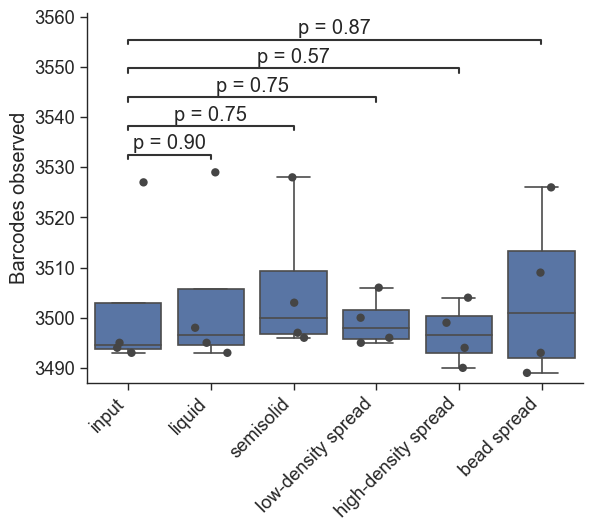

In [11]:
unique_seqs_df = sample_stats_df[sample_stats_df['variable'] == 'unique seqs']

# Plot boxplot
ax = sns.boxplot(data=unique_seqs_df, x='sample', y='value', order=sample_names, color=sns.color_palette()[0], fliersize=0)

# Add stat annotations
pairs = [('input', 'liquid'), ('input', 'semisolid'), ('input', 'high-density spread'), ('input', 'low-density spread'), ('input', 'bead spread')]
annotator = Annotator(ax, pairs, data=unique_seqs_df, x='sample', y='value', order=sample_names)
annotator._pvalue_format.pvalue_format_string = "{:#.2g}" # Set p-value format
annotator.configure(test="t-test_welch", text_format='full', loc='inside', show_test_name=False)
annotator.apply_and_annotate()

# Plot individual points
sns.stripplot(data=unique_seqs_df, x='sample', y='value', order=sample_names, color=POINT_COLOR, size=POINT_SIZE, jitter=0.2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Barcodes observed')
plt.savefig('images/MORF_count.svg', format='svg')
plt.show()

Compare Gini coefficients (uniformity) of libraries (Fig. 3b).

input vs. liquid: Welch's t-test independent samples, P_val:5.128e-01 t=-7.078e-01
input vs. semisolid: Welch's t-test independent samples, P_val:2.301e-01 t=-1.416e+00
input vs. low-density spread: Welch's t-test independent samples, P_val:1.027e-01 t=-2.060e+00
input vs. high-density spread: Welch's t-test independent samples, P_val:2.755e-02 t=-2.909e+00
input vs. bead spread: Welch's t-test independent samples, P_val:4.278e-01 t=-8.807e-01


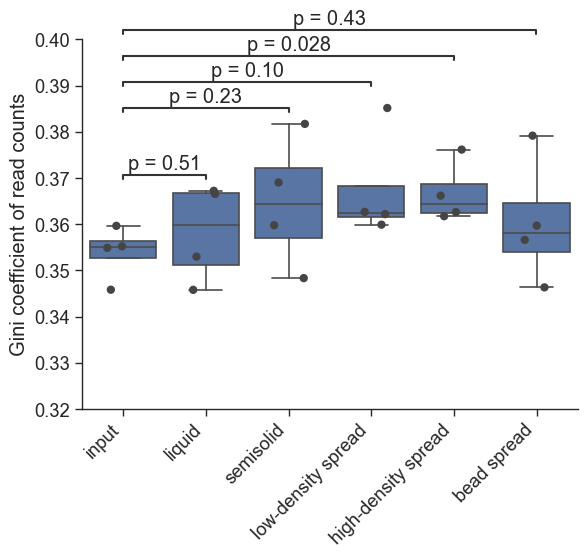

In [12]:
gini_df = sample_stats_df[sample_stats_df['variable'] == 'gini']

# Plot boxplot
ax = sns.boxplot(data=gini_df, x='sample', y='value', order=sample_names, color=sns.color_palette()[0], fliersize=0)

# Add stat annotations
pairs = [('input', 'liquid'), ('input', 'semisolid'), ('input', 'high-density spread'), ('input', 'low-density spread'), ('input', 'bead spread')]
annotator = Annotator(ax, pairs, data=gini_df, x='sample', y='value', order=sample_names)
annotator._pvalue_format.pvalue_format_string = "{:#.2g}" # Set p-value format
annotator.configure(test="t-test_welch", text_format='full', loc='inside', show_test_name=False)
annotator.apply_and_annotate()

# Plot individual points
sns.stripplot(data=gini_df, x='sample', y='value', order=sample_names, color=POINT_COLOR, size=POINT_SIZE, jitter=0.2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylim(0.32, 0.4)
plt.ylabel('Gini coefficient of read counts')
plt.savefig('images/MORF_gini.svg', format='svg')
plt.show()

Plot the distribution of counts for each sample.

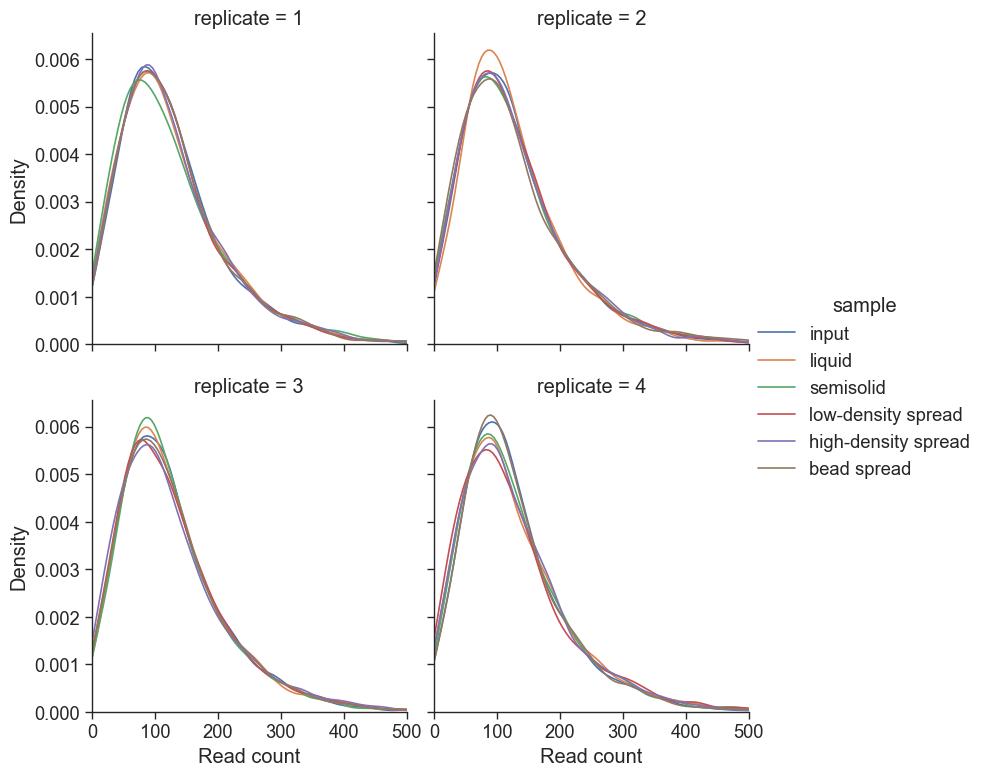

In [13]:
g = sns.FacetGrid(merged_df, col='replicate', hue='sample', col_wrap=2, height=4)
g.map(sns.kdeplot, 'count')
plt.xlim([0,500])
g.add_legend()
for axes in g.axes.flat:
    axes.set_xlabel('Read count')
plt.show()

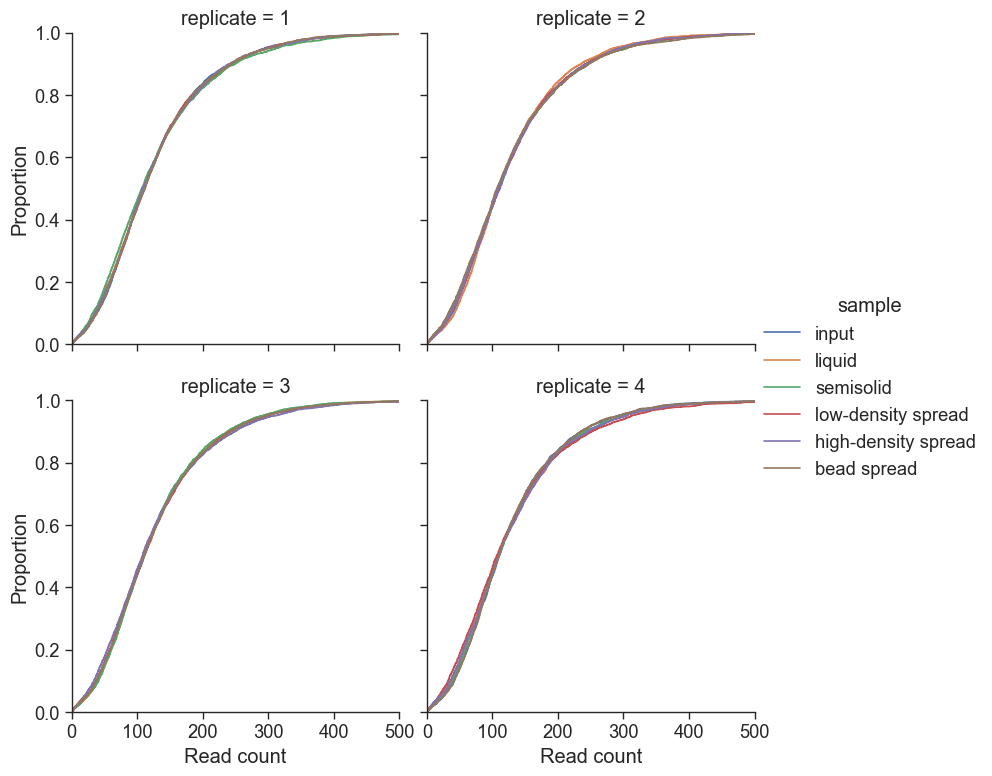

In [14]:
g = sns.FacetGrid(merged_df, col='replicate', hue='sample', col_wrap=2, height=4)
g.map(sns.ecdfplot, 'count')
plt.xlim([0,500])
g.add_legend()
for axes in g.axes.flat:
    axes.set_xlabel('Read count')
plt.show()

Plot distribution of read counts for a representative replicate (Fig. 3c).

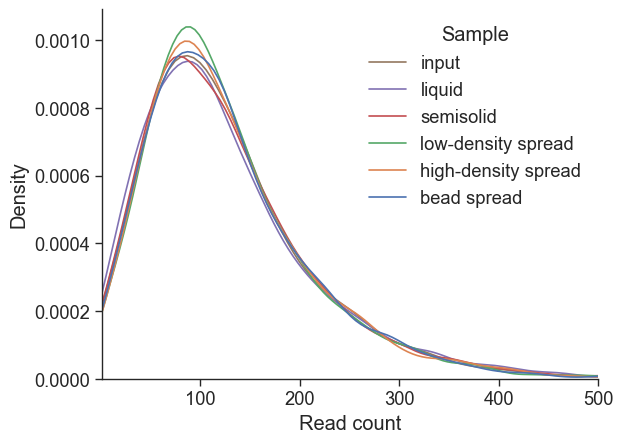

In [15]:
rep3_df = merged_df.loc[merged_df['replicate'] == 3]
sns.kdeplot(data=rep3_df, x='count', hue='sample', legend=False)
plt.xlim([1,500])
plt.xlabel('Read count')
plt.legend(title='Sample', loc='upper right', labels=sample_names, edgecolor='white')
plt.savefig('images/MORF_rep3_kde.svg', format='svg')
plt.show()

For each replicate, plot correlation between each sample's counts and the mean of the input counts for the three other replicates. This is done so that input vs input correlations are directly comparable to all other sample vs input correlations. Note that any barcodes not shared between each sample and the input are given a count of 0 for the sample in which they don't appear.

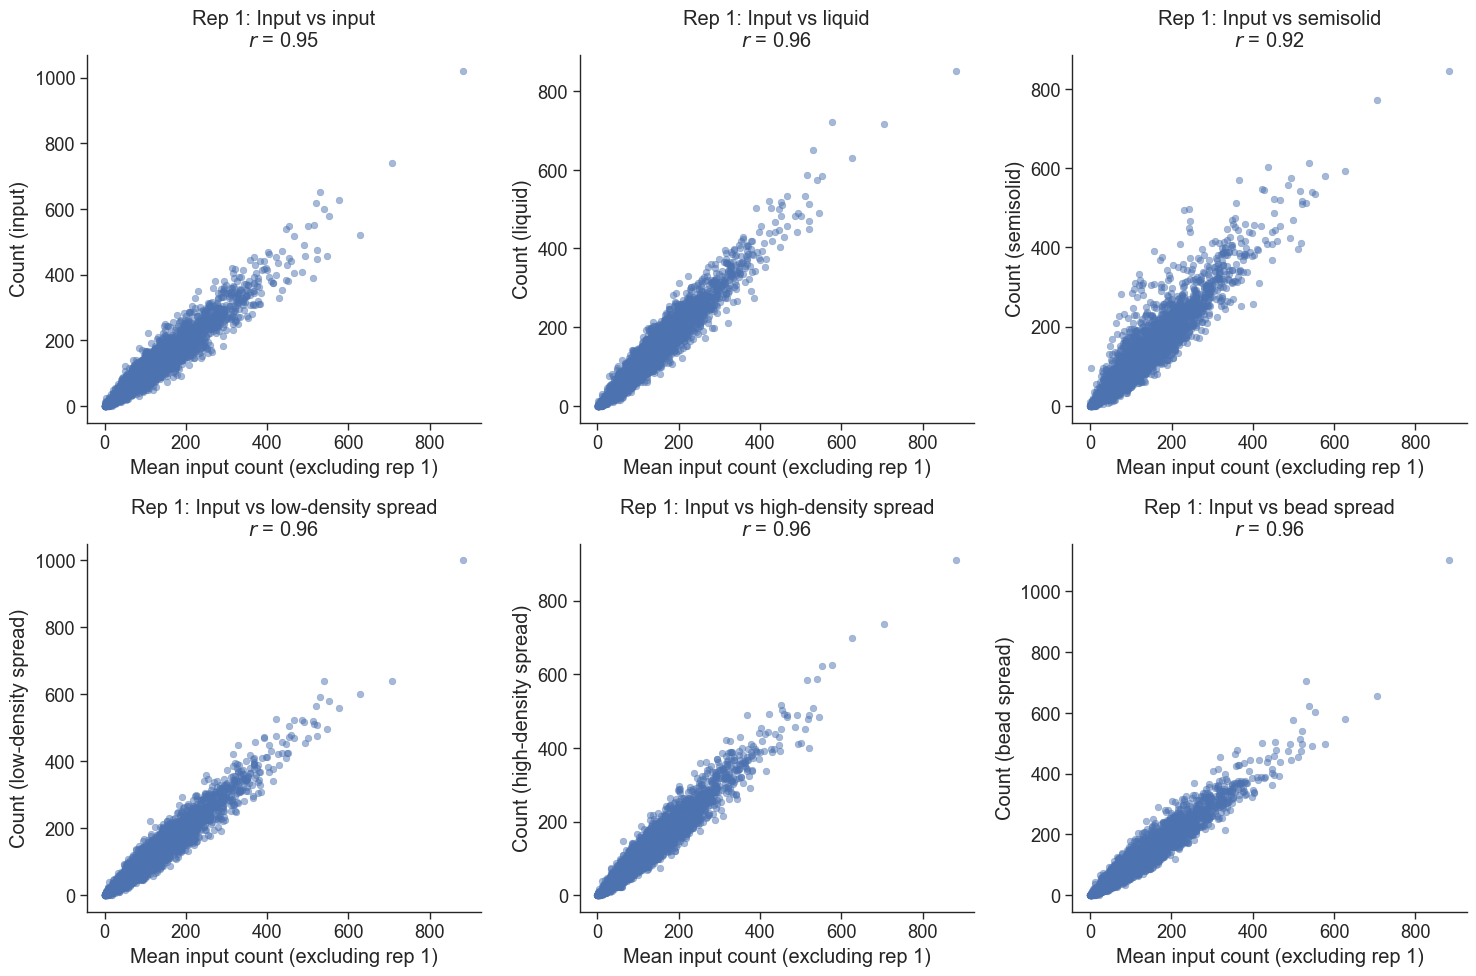

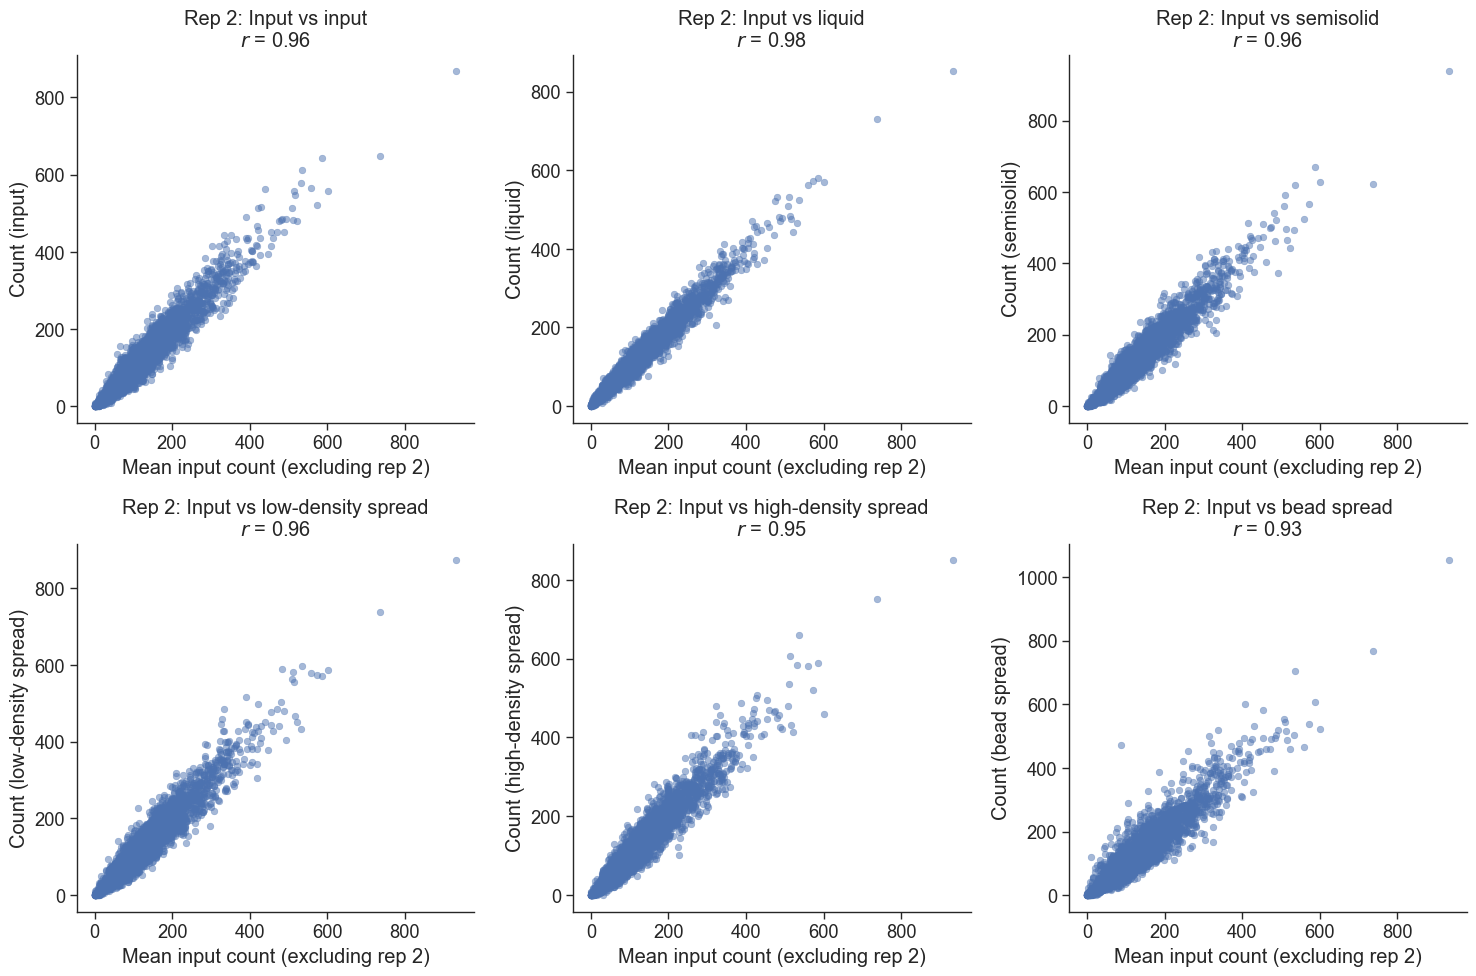

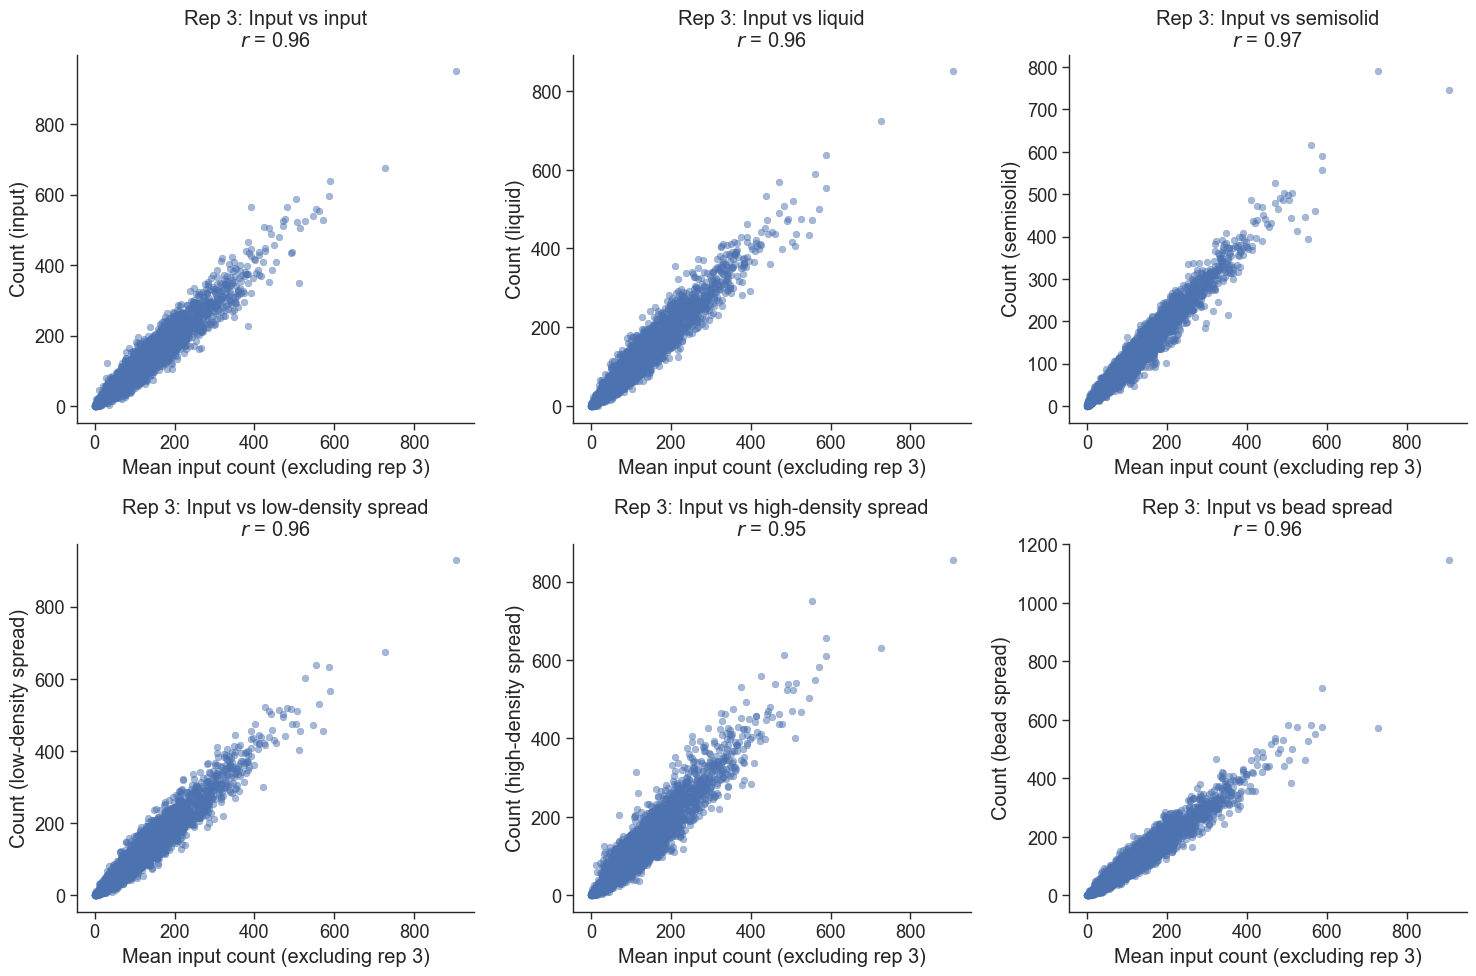

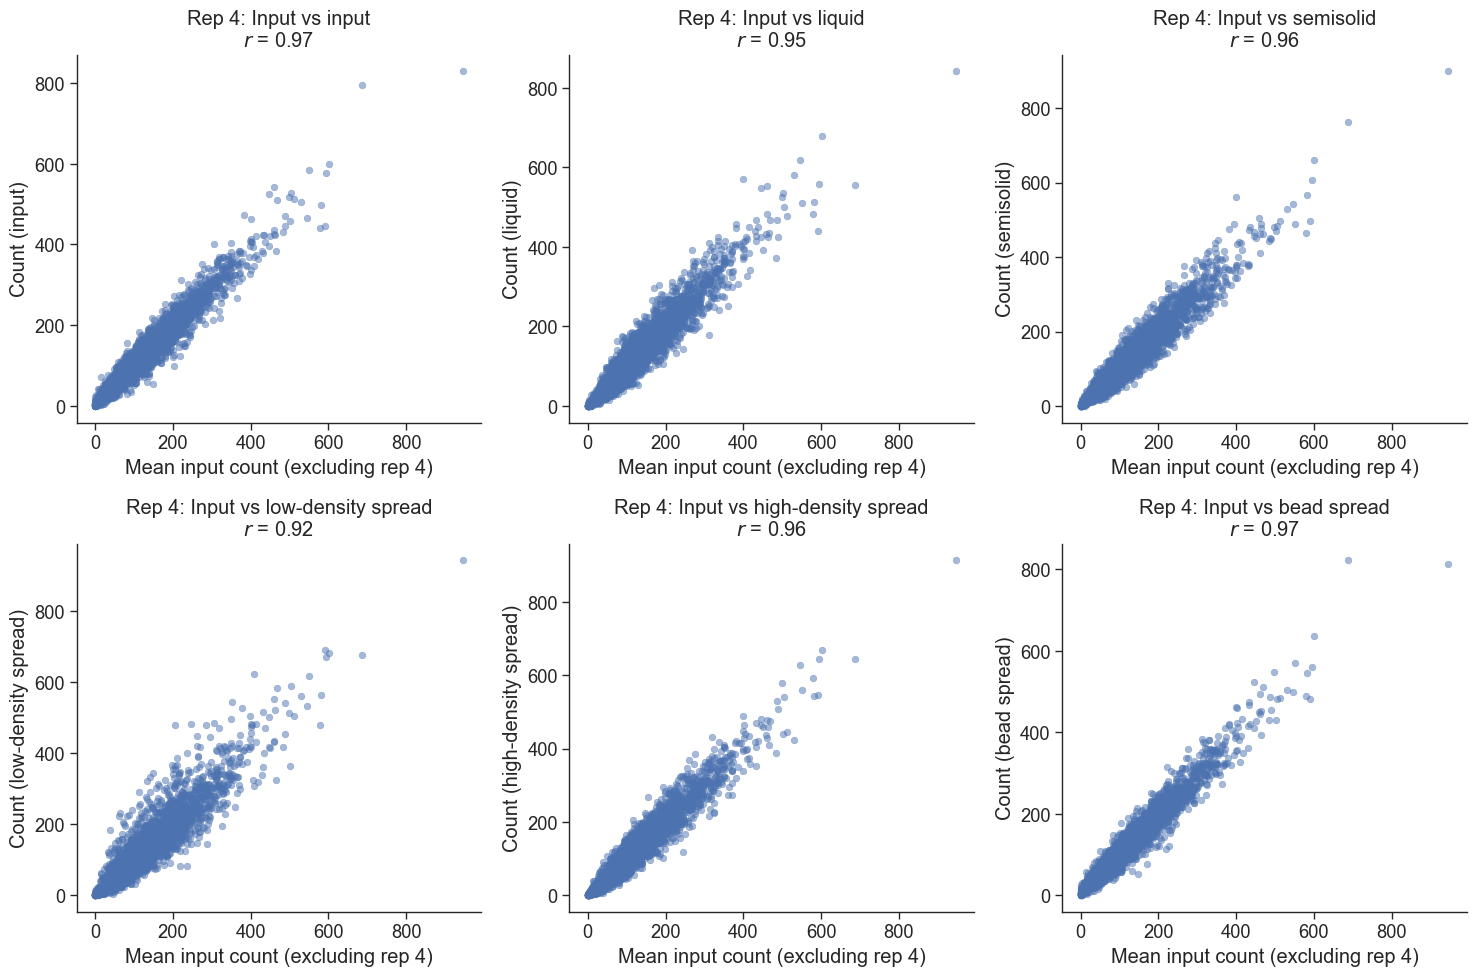

In [16]:
pearson_corrs = []

# Set up df for calculating input count means
input_df = merged_df[merged_df['sample'] == 'input'].pivot_table(index='sequence', columns='replicate', values='count', fill_value=0)

for rep in range(1, 5):
  # Subset for the current replicate
  rep_df = merged_df[merged_df['replicate'] == rep]
  samples = rep_df['sample'].unique()

  # Calculate input count average for the other 3 replicates and make dict
  other_reps_input_df = input_df.drop(rep, axis=1)
  other_reps_input_df['mean'] = other_reps_input_df.mean(axis=1)
  
  # Set up plot
  n_cols = 3
  n_rows = 2
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

  for i, sample in enumerate(samples):
    # Merge input and sample dataframes on barcodes and fill NaNs with 0
    sample_df = rep_df[rep_df['sample'] == sample]
    input_sample_merged_df = pd.merge(other_reps_input_df, sample_df, on='sequence', how='outer').fillna(0)
    
    # Calculate Pearson correlation and save to list
    pearson_corr = stats.pearsonr(input_sample_merged_df['count'], input_sample_merged_df['mean'])[0]
    pearson_corrs.append((sample, rep, pearson_corr))
    
    # Plot correlations
    ax = axes[i // n_cols, i % n_cols]
    sns.scatterplot(data=input_sample_merged_df, x='mean', y='count', ax=ax, alpha=0.5, edgecolor=None)
    ax.set_title(f'Rep {rep}: Input vs {sample}\n$r$ = {pearson_corr:.2f}')
    ax.set_xlabel(f'Mean input count (excluding rep {rep})')
    ax.set_ylabel(f'Count ({sample})')

  plt.tight_layout()
  plt.show()

Compare Pearson correlation between sample and input counts (Fig. 3d).

input vs. liquid: Welch's t-test independent samples, P_val:6.022e-01 t=-5.562e-01
input vs. semisolid: Welch's t-test independent samples, P_val:5.935e-01 t=5.846e-01
input vs. low-density spread: Welch's t-test independent samples, P_val:4.245e-01 t=8.987e-01
input vs. high-density spread: Welch's t-test independent samples, P_val:5.704e-01 t=6.025e-01
input vs. bead spread: Welch's t-test independent samples, P_val:6.921e-01 t=4.270e-01


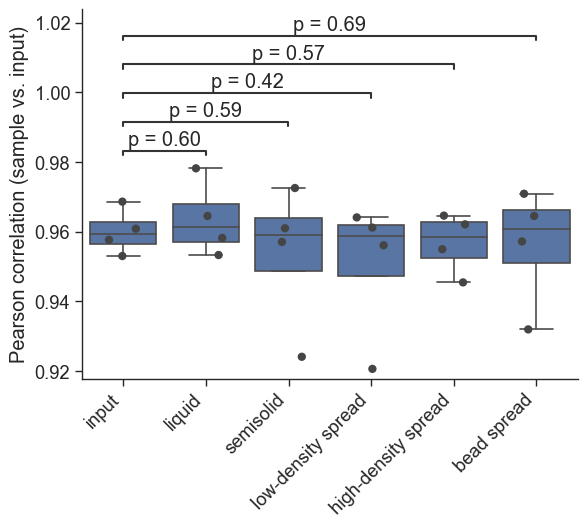

In [17]:
corrs_df = pd.DataFrame(pearson_corrs, columns=['sample', 'rep', 'pearson_corr'])

# Plot boxplot
ax = sns.boxplot(data=corrs_df, x='sample', y='pearson_corr', order=sample_names, color=sns.color_palette()[0], fliersize=0)

# Add stat annotations
pairs = [('input', 'liquid'), ('input', 'semisolid'), ('input', 'high-density spread'), ('input', 'low-density spread'), ('input', 'bead spread')]
annotator = Annotator(ax, pairs, data=corrs_df, x='sample', y='pearson_corr', order=sample_names)
annotator._pvalue_format.pvalue_format_string = "{:#.2g}" # Set p-value format
annotator.configure(test="t-test_welch", text_format='full', loc='inside', show_test_name=False)
annotator.apply_and_annotate()

# Plot individual points
sns.stripplot(data=corrs_df, x='sample', y='pearson_corr', color=POINT_COLOR, size=POINT_SIZE, order=sample_names, jitter=0.2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Pearson correlation (sample vs. input)')
plt.savefig('images/MORF_pearson_correlation.svg', format='svg')
plt.show()

Look at relationship between insert size and read count for the input libraries.

In [18]:
# Get mean count for each sequence in the input samples. Counts set to zero if sequence is not present in an input sample
input_df = merged_df[merged_df['sample'] == 'input'].pivot_table(index='sequence', columns='replicate', values='count', fill_value=0)
avg_input_df = input_df.copy()
avg_input_df['mean count'] = input_df.mean(axis=1)

# Get means for each grouping of three replicates
for i in range(1, 5):
  avg_input_df[f'mean count drop {i}'] = input_df.drop(i, axis=1).mean(axis=1)
avg_input_df = avg_input_df.reset_index()

# Merge the average count back into the MORF df to get ORF lengths
avg_input_df = MORF_df.merge(avg_input_df, left_on='Barcode Sequence', right_on='sequence', how='right')
avg_input_df['ORF length'] = avg_input_df['ORF sequence'].apply(len)
avg_input_df = avg_input_df[['sequence', 'ORF sequence', 'Name', 'ORF length', 'mean count', 'mean count drop 1', 'mean count drop 2', 'mean count drop 3', 'mean count drop 4']]
print(len(avg_input_df))
avg_input_df.head()


3528


,sequence,ORF sequence,Name,ORF length,mean count,mean count drop 1,mean count drop 2,mean count drop 3,mean count drop 4
0,AAAACCCAGTTATGGCCTGGAGAC,ATGATGGCTGAAAACAATTTAAAAATGCTAAAGATTCAACAGTGTG...,TFORF3221,2073,55.25,55.000000,48.333333,60.000000,57.666667
1,AAAATGCTCCCGTCCGTTGGGCCA,ATGGCGGAGAGCTGGCTGCGCCTCTCGGGAGCCGGGCCGGCGGAGG...,TFORF3230,1263,89.00,92.000000,77.000000,95.666667,91.333333
2,AAACACCGCTCCGTGGGCAGAAGA,ATGAACATGTCTCAGGCATCAGTGTCATTCCAGGACGTGACTGTGG...,TFORF2560,3177,45.75,40.333333,43.000000,51.000000,48.666667
3,AAACACTATCCCAACAGACACTGC,ATGAGTTCGTACTTCGTGAACCCGCTGTACTCCAAGTACAAGGCGG...,TFORF2349,870,198.50,191.666667,197.333333,207.333333,197.666667
4,AAACAGACCTGTAATAGAGTCCCT,ATGGCGGCCAATGTGGGATCGATGTTTCAATATTGGAAGCGCTTTG...,TFORF1964,1896,167.50,167.000000,163.666667,179.000000,160.333333


Plot log10(read count) vs ORF length to see the existing length bias in the input library (Fig. 4a)

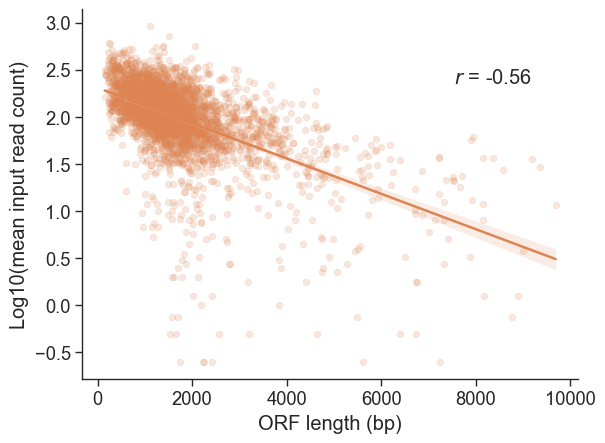

In [19]:
sns.scatterplot(x=avg_input_df['ORF length'], y=np.log10(avg_input_df['mean count']), alpha=0.2, edgecolor=None, color=sns.color_palette()[1])
sns.regplot(x=avg_input_df['ORF length'], y=np.log10(avg_input_df['mean count']), scatter=None, color=sns.color_palette()[1])
r, p = stats.pearsonr(x=avg_input_df['ORF length'], y=np.log10(avg_input_df['mean count']))
ax = plt.gca()
plt.text(.75, .8, "$r$ = {:.2f}".format(r), transform=ax.transAxes)
plt.ylabel('Log10(mean input read count)')
plt.xlabel('ORF length (bp)')
plt.savefig('images/MORF_log_count_vs_ORF_length.svg', format='svg')
plt.show()

There is strong trend toward lower count for larger insert size. Now see if any of the culturing methods make this trend worse when compared to the input counts.

In [20]:
def calculate_ratio(group):
  rep = group['replicate'].iloc[0]
  counts_mapping = avg_input_df.set_index('sequence')[f'mean count drop {rep}'].to_dict()
  group['log2(fc)'] = np.log2(group['count'] / group['sequence'].map(counts_mapping))
  return group

ratio_df = merged_df.groupby(['sample', 'replicate'], group_keys=False).apply(calculate_ratio)
start_len = len(ratio_df)
# Drop instances where ratio was 0 or inf
ratio_df = ratio_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['log2(fc)'])
print(f"{start_len - len(ratio_df)} rows dropped.")

74 rows dropped.


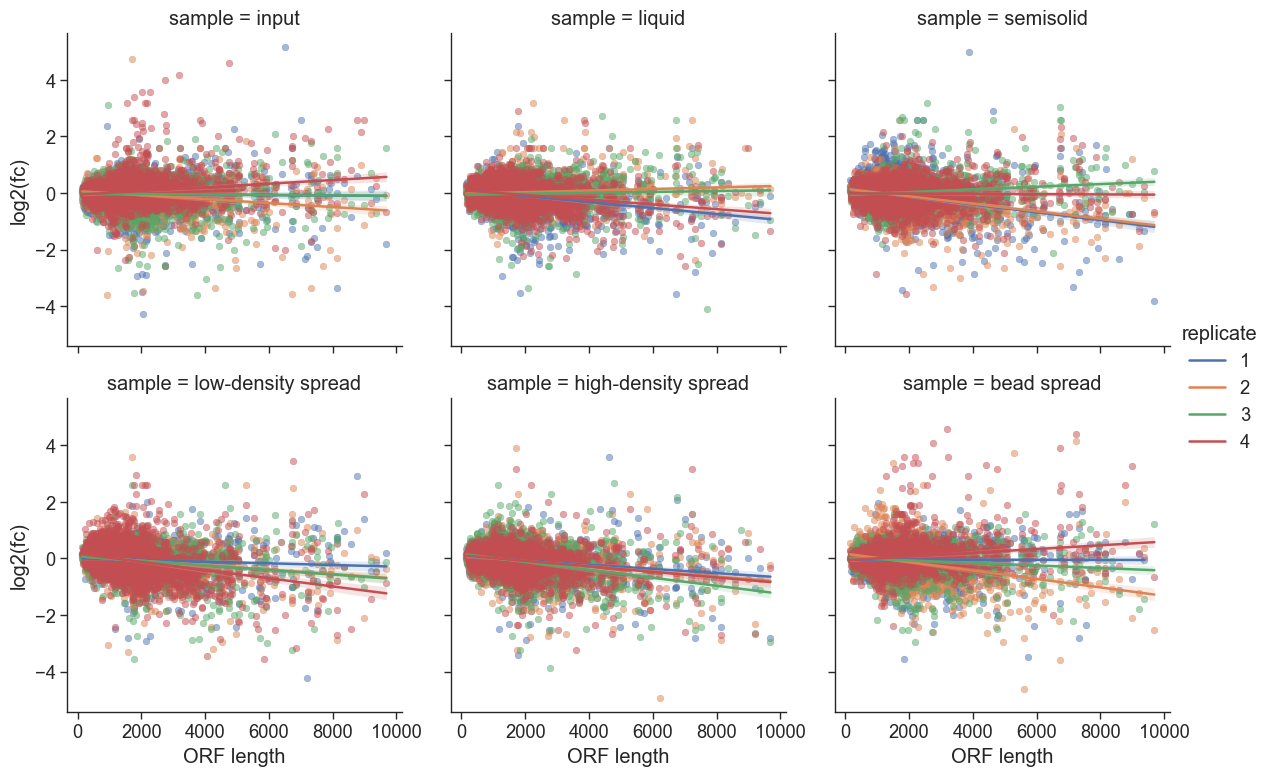

In [21]:
g = sns.FacetGrid(ratio_df, col='sample', hue='replicate', col_wrap=3, height=4)
g.map(sns.scatterplot, 'ORF length', 'log2(fc)', alpha=0.5, edgecolor=None)
g.map(sns.regplot, 'ORF length', 'log2(fc)', scatter=False)
g.add_legend()
plt.savefig('images/MORF_log2fc.svg', format='svg')
plt.show()


Example of slope calculation for a single replicate (Fig. 4b).

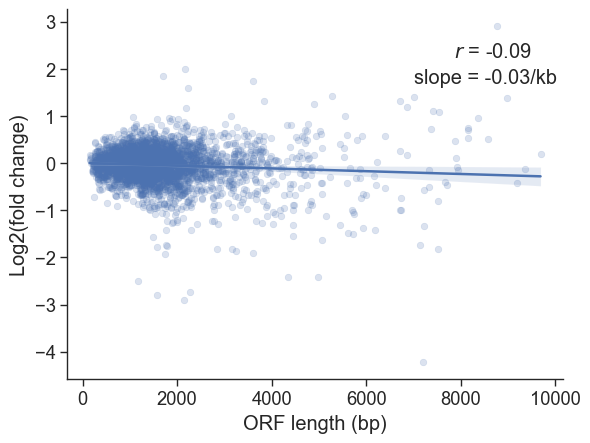

In [22]:
sample = ratio_df[(ratio_df['sample'] == 'low-density spread') & (ratio_df['replicate'] == 1)]
sns.scatterplot(data=sample, x='ORF length', y='log2(fc)', alpha=0.2, edgecolor=None)
sns.regplot(data=sample, x='ORF length', y='log2(fc)', scatter=False)
plt.ylabel('Log2(fold change)')
plt.xlabel('ORF length (bp)')
slope = stats.linregress(x=sample['ORF length'], y=sample['log2(fc)'])[0] * 1000
r, p = stats.pearsonr(x=sample['ORF length'], y=sample['log2(fc)'])
ax = plt.gca()
plt.text(.78, .87, "$r$ = {:.2f}".format(r), transform=ax.transAxes)
plt.text(.7, .8, "slope = {:.2f}/kb".format(slope), transform=ax.transAxes)
plt.savefig('images/MORF_log2fc_low_spread_slope.svg', format='svg')
plt.show()

Compare slopes of all samples to input slopes (Fig. 4c).

input vs. liquid: Welch's t-test independent samples, P_val:4.993e-01 t=7.208e-01
input vs. semisolid: Welch's t-test independent samples, P_val:3.818e-01 t=9.609e-01
input vs. low-density spread: Welch's t-test independent samples, P_val:7.643e-02 t=2.148e+00
input vs. high-density spread: Welch's t-test independent samples, P_val:3.157e-02 t=3.085e+00
input vs. bead spread: Welch's t-test independent samples, P_val:6.301e-01 t=5.127e-01


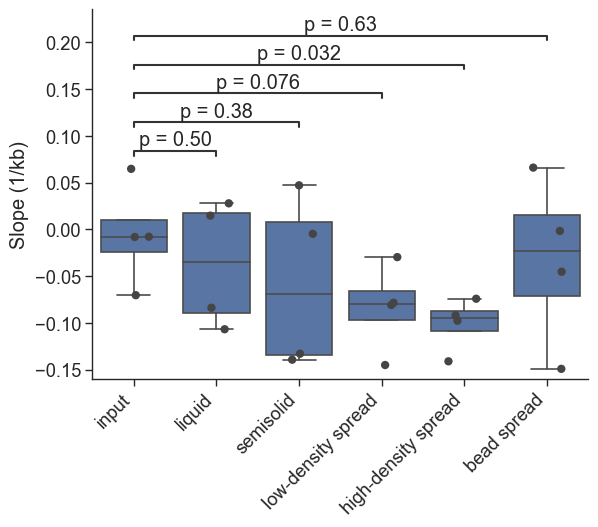

In [23]:
# Calculate slopes
slopes = []
for sample in sample_names:
  for rep in range(1, 5):
    sample_df = ratio_df[(ratio_df['sample'] == sample) & (ratio_df['replicate'] == rep)]
    slope = stats.linregress(x=sample_df['ORF length'], y=sample_df['log2(fc)'])[0] * 1000
    slopes.append((sample, rep, slope))
slopes = pd.DataFrame(slopes, columns=['sample', 'replicate', 'slope'])

# Plot boxplot
ax = sns.boxplot(data=slopes, x='sample', y='slope', order=sample_names, color=sns.color_palette()[0], fliersize=0)

# Add stat annotations
pairs = [('input', 'liquid'), ('input', 'semisolid'), ('input', 'high-density spread'), ('input', 'low-density spread'), ('input', 'bead spread')]
annotator = Annotator(ax, pairs, data=slopes, x='sample', y='slope', order=sample_names)
annotator._pvalue_format.pvalue_format_string = "{:#.2g}" # Set p-value format
annotator.configure(test="t-test_welch", text_format='full', loc='inside', show_test_name=False)
annotator.apply_and_annotate()

# Plot individual points
sns.stripplot(data=slopes, x='sample', y='slope', order=sample_names, color=POINT_COLOR, size=POINT_SIZE, jitter=0.2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Slope (1/kb)')
plt.savefig('images/MORF_ORF_length_vs_log2fc_slope.svg', format='svg')
plt.show()